In [120]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader


def basic_data_load(data_path):
	"""
	Parameters
	----------
	args.dataset.data_path : str
		데이터 경로를 설정할 수 있는 parser

	Returns
	-------
	data : dict
		학습 및 테스트 데이터가 담긴 사전 형식의 데이터를 반환합니다
	"""

	######################## DATA LOAD
	# users = pd.read_csv(args.dataset.data_path + 'users.csv')
	# books = pd.read_csv(args.dataset.data_path + 'books.csv')
	train_df = pd.read_csv(data_path + 'train_ratings.csv')
	test_df = pd.read_csv(data_path + 'test_ratings.csv')
	sub = pd.read_csv(data_path + 'sample_submission.csv')

	all_df = pd.concat([train_df, test_df], axis=0)

	sparse_cols = ['user_id', 'isbn']

	# 라벨 인코딩하고 인덱스 정보를 저장
	label2idx, idx2label = {}, {}
	for col in sparse_cols:
		all_df[col] = all_df[col].fillna('unknown')
		unique_labels = all_df[col].astype("category").cat.categories
		label2idx[col] = {label: idx for idx, label in enumerate(unique_labels)}
		idx2label[col] = {idx: label for idx, label in enumerate(unique_labels)}
		train_df[col] = train_df[col].map(label2idx[col])
		test_df[col] = test_df[col].map(label2idx[col])

	field_dims = [len(label2idx[col]) for col in sparse_cols]

	data = {
		'train': train_df,
		'test': test_df.drop(['rating'], axis=1),
		'field_dims': field_dims,
		'label2idx': label2idx,
		'idx2label': idx2label,
		'sub': sub,
	}

	return data


def basic_data_split(args, data):
	"""
	Parameters
	----------
	args.dataset.valid_ratio : float
		Train/Valid split 비율을 입력합니다.
	args.seed : int
		데이터 셔플 시 사용할 seed 값을 입력합니다.

	Returns
	-------
	data : dict
		data 내의 학습 데이터를 학습/검증 데이터로 나누어 추가한 후 반환합니다.
	"""
	if args.dataset.valid_ratio == 0:
		data['X_train'] = data['train'].drop('rating', axis=1)
		data['y_train'] = data['train']['rating']

	else:
		X_train, X_valid, y_train, y_valid = train_test_split(
			data['train'].drop(['rating'], axis=1),
			data['train']['rating'],
			test_size=args.dataset.valid_ratio,
			random_state=args.seed,
			shuffle=True
		)
		data['X_train'], data['X_valid'], data['y_train'], data['y_valid'] = X_train, X_valid, y_train, y_valid

	return data


def basic_data_loader(args, data):
	"""
	Parameters
	----------
	args.dataloader.batch_size : int
		데이터 batch에 사용할 데이터 사이즈
	args.dataloader.shuffle : bool
		data shuffle 여부
	args.dataloader.num_workers: int
		dataloader에서 사용할 멀티프로세서 수
	args.dataset.valid_ratio : float
		Train/Valid split 비율로, 0일 경우에 대한 처리를 위해 사용합니다.
	data : dict
		basic_data_split 함수에서 반환된 데이터

	Returns
	-------
	data : dict
		DataLoader가 추가된 데이터를 반환합니다.
	"""

	train_dataset = TensorDataset(torch.LongTensor(data['X_train'].values), torch.LongTensor(data['y_train'].values))
	valid_dataset = TensorDataset(torch.LongTensor(data['X_valid'].values),
								  torch.LongTensor(data['y_valid'].values)) if args.dataset.valid_ratio != 0 else None
	test_dataset = TensorDataset(torch.LongTensor(data['test'].values))

	train_dataloader = DataLoader(train_dataset, batch_size=args.dataloader.batch_size, shuffle=args.dataloader.shuffle,
								  num_workers=args.dataloader.num_workers)
	valid_dataloader = DataLoader(valid_dataset, batch_size=args.dataloader.batch_size, shuffle=False,
								  num_workers=args.dataloader.num_workers) if args.dataset.valid_ratio != 0 else None
	test_dataloader = DataLoader(test_dataset, batch_size=args.dataloader.batch_size, shuffle=False,
								 num_workers=args.dataloader.num_workers)

	data['train_dataloader'], data['valid_dataloader'], data[
		'test_dataloader'] = train_dataloader, valid_dataloader, test_dataloader

	return data


In [122]:
data = basic_data_load('../data/')

In [123]:
train_df = data['train']
test_df = data['test']

In [124]:
train_df

,user_id,isbn,rating
0,0,39,4
1,16631,39,7
2,30285,39,8
3,48760,39,8
4,51452,39,9
...,...,...,...
306790,68062,87948,7
306791,68066,75092,6
306792,68066,109944,7
306793,68066,113224,7


In [125]:
# test_df에 있는 user_id가 train_df에 없는 개수를 탐색
new_users = test_df[~test_df.user_id.isin(train_df.user_id)].user_id.nunique()
new_books = test_df[~test_df.isbn.isin(train_df.isbn)].isbn.nunique()
print(f"new_users: {new_users}, new_books: {new_books}")

new_users: 8266, new_books: 19793


In [126]:
# 각 유저별 평점 평균을 구하고 train_df, test_df에 추가
user_rating_mean = train_df.groupby('user_id')['rating'].mean()
train_df['user_rating_mean'] = train_df.user_id.map(user_rating_mean)
test_df['user_rating_mean'] = test_df.user_id.map(user_rating_mean)

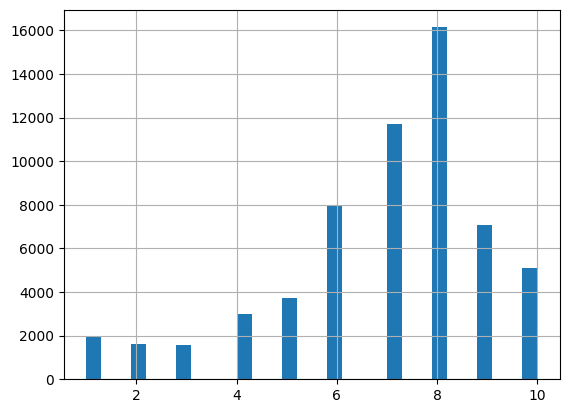

In [127]:
# 각 유저별 평점 평균을 int로 변환하여 rating 별 유저 개수 histogram
user_rating_mean_int = user_rating_mean.round().astype(int)
user_rating_mean_int.hist(bins=30)
plt.show()

In [149]:
# 각 유저의 평점 개수를 구하고 train_df,  test_df에 추가
user_rating_count = train_df['user_id'].value_counts()
train_df['user_rating_count'] = train_df.user_id.map(user_rating_count)
test_df['user_rating_count'] = test_df.user_id.map(user_rating_count)
# train_df에 없던 새로운 유저의 경우 평점 개수를 0으로 설정
test_df['user_rating_count'] = test_df['user_rating_count'].fillna(0)

In [150]:
# isbn 별 평점 평균을 구하고 train_df, test_df에 추가
book_rating_mean = train_df.groupby('isbn')['rating'].mean()
train_df['book_rating_mean'] = train_df.isbn.map(book_rating_mean)
test_df['book_rating_mean'] = test_df.isbn.map(book_rating_mean)

,user_id,isbn,user_rating_mean,user_rating_count,book_rating_mean
0,2719,39,6.779891,5520.0,6.857143
1,28656,39,7.734694,49.0,6.857143
2,37434,4667,8.400000,5.0,8.000000
3,38564,32059,8.000000,2.0,7.600000
4,16742,42311,8.090909,11.0,7.571429
...,...,...,...,...,...
76694,67993,126235,6.666667,3.0,NaN
76695,68001,141816,7.000000,4.0,NaN
76696,68013,133571,7.032258,31.0,NaN
76697,68024,145168,3.000000,3.0,NaN


In [ ]:
# collaaborative filtering matrix factorization with pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.autograd import Variable
